In [1]:
from collections import defaultdict
from pathlib import Path
import json

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter


import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go


from brats21 import utils as bu
from brats21.dash.cont_err_plot import cont_err_plot
from brats21 import evaluation as valid

---------

In [2]:
# Global settings
TRAINED_MODEL_PATH = Path("/sc-scratch/sc-scratch-gbm-radiomics/nnUNet_trained_models")
MODEL_PREDICTION_PATH = Path("/sc-scratch/sc-scratch-gbm-radiomics/task1_evaluation/output")

--------

In [3]:
performance = pd.DataFrame(bu.get_model_histroy(TRAINED_MODEL_PATH))

In [22]:
df = performance.groupby(["name", "iteration"]).mean().reset_index()

In [23]:
df.loc[:, "valid_metric"] = bu.mean_smooth(df.loc[:, "valid_metric"], 5)
df.loc[:, "train_loss"] = bu.mean_smooth(df.loc[:, "train_loss"], 5)
df.loc[:, "valid_loss"] = bu.mean_smooth(df.loc[:, "valid_loss"], 5)

In [24]:
df.name.unique()

array(['BraTS20', 'MHCA', 'MHSA', 'ResNetDec', 'ResNetEnc', 'SegNet',
       'SegNetMHCA', 'SegNetMHSA', 'SegNetPool5Conv3', 'SegNetPool5Conv4',
       'SegNetPool6Conv2', 'SegNetPool6Conv3', 'SegNetPool6Conv4',
       'SegNetTransformer', 'SegResNetDec', 'SegResNetEnc', 'Transformer',
       'miniSegNet', 'nnUNet',
       'nnUNetTrainerSegNetPool432__nnUNetPlansv2.1',
       'nnUNetTrainerSegNetPool43__nnUNetPlansv2.1',
       'nnUNetTrainerSegNetPool4__nnUNetPlansv2.1',
       'nnUNetTrainerV2SegNetTversky__nnUNetPlansv2.1',
       'nnUNetTrainerV2_focalLoss__nnUNetPlansv2.1'], dtype=object)

In [25]:
query_models = [
    "BraTS20",
    "SegNet",
    "nnUNetTrainerSegNetPool432__nnUNetPlansv2.1",
    "nnUNetTrainerSegNetPool43__nnUNetPlansv2.1",
    "nnUNetTrainerSegNetPool4__nnUNetPlansv2.1",
]

In [26]:
df = df[df.name.isin(query_models)]

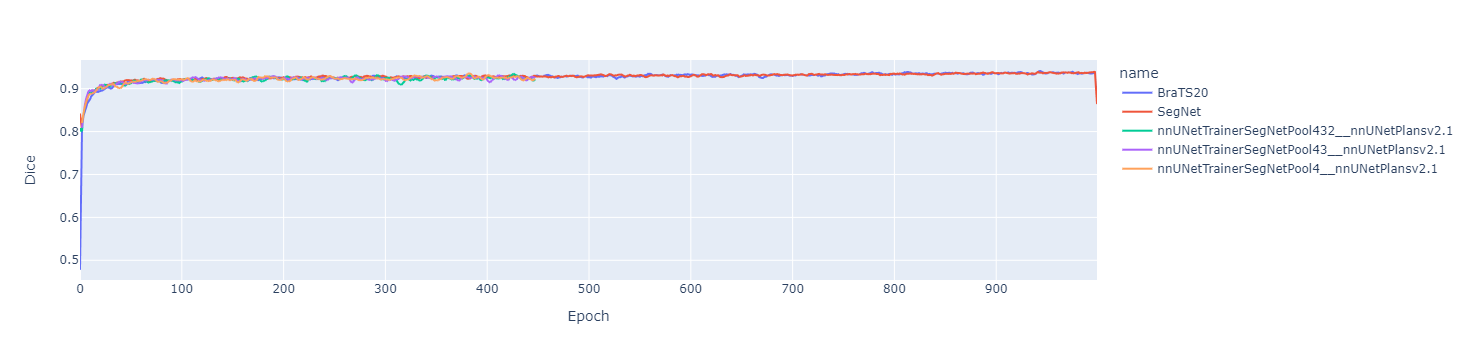

In [27]:
px.line(df, x="iteration", y="valid_metric", color="name", labels=dict(valid_metric="Dice", iteration="Epoch"))

------------------
## PREDICTION RESULTS


-------------------

In [3]:
summarys = [valid.Summary(path=path, name=path.parents[1].name) for path in MODEL_PREDICTION_PATH.rglob("summary.json")]
for s in summarys:
    print(s.name, len(s.image))

nnUNetTrainerSegNetTransformer 250
nnUNetTrainerSegNetMHSA 250
nnUNetTrainerSegResNetEnc 250
nnUNetTrainerSegResNetDec 250
nnUNetTrainerV2BraTSSegnet 250
nnUNetTrainerV2BraTSRegions 250


In [29]:
for s in summarys:
    print(s)
    print()

Name:	nnUNetTrainerSegNetTransformer\#Evaluations:	250
Mean Resuluts:
Dice: {'Edema': 0.8665953843609125, 'Necrotic': 0.7445930356818178, 'Enhancing': 0.8607192179208112}
Jaccard: {'Edema': 0.7840633247638207, 'Necrotic': 0.6642431094799808, 'Enhancing': 0.7931545275719806}
Precision: {'Edema': 0.8831650238459131, 'Necrotic': 0.773467055372688, 'Enhancing': 0.8832094365555145}
Recall: {'Edema': 0.8701863760145601, 'Necrotic': 0.7967577192594171, 'Enhancing': 0.8852153856074972}

Name:	nnUNetTrainerSegNetMHSA\#Evaluations:	250
Mean Resuluts:
Dice: {'Edema': 0.8740766757469834, 'Necrotic': 0.7527473919522063, 'Enhancing': 0.8617875730989725}
Jaccard: {'Edema': 0.7937343069322148, 'Necrotic': 0.6725616935438808, 'Enhancing': 0.7949526832050943}
Precision: {'Edema': 0.8909255352877855, 'Necrotic': 0.78543573691911, 'Enhancing': 0.8807214836043351}
Recall: {'Edema': 0.8753024068368942, 'Necrotic': 0.8055467015651696, 'Enhancing': 0.8880128626553918}

Name:	nnUNetTrainerSegResNetEnc\#Evaluat

In [37]:
NAMING = {
    'nnUNetTrainerSegNetTransformer': "Transformer",
    'nnUNetTrainerSegNetMHSA': "MHSA",
    'nnUNetTrainerSegResNetEnc': "ResNet-Encoder",
    'nnUNetTrainerSegResNetDec': "ResNet-Decoder",
    'nnUNetTrainerV2BraTSSegnet': "SegNet",
    'nnUNetTrainerV2BraTSRegions': "UNet",
}

In [38]:
def get_summary_df(summarys, metric):
    df = defaultdict(list)
    for summary in summarys:
        for result in summary.image:
            for c in ["Edema", "Enhancing", "Necrotic"]:
                df["Model"].append(NAMING[summary.name])
                df["Class"].append(c)
                df["Value"].append(result.__getattribute__(metric)[c])
    return pd.DataFrame(df)

In [39]:
false_omission = get_summary_df(summarys, "false_omission")


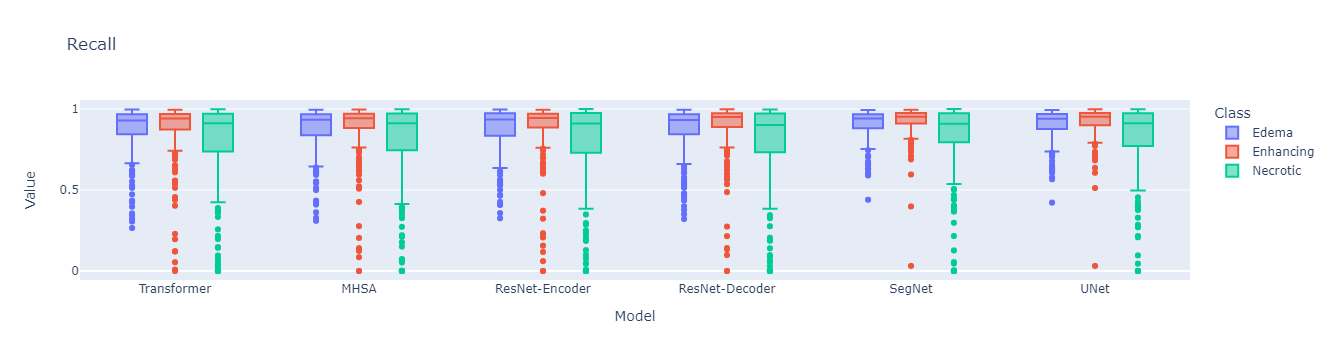

In [43]:
METRIC = "Recall"
recall = get_summary_df(summarys, METRIC.lower())
px.box(recall, x="Model", y="Value", color="Class", title=METRIC)

In [ ]:
MODEL_PREDICTION_PATH = Path(
    "/sc-scratch/sc-scratch-gbm-radiomics/task1_evaluation/output"
)

summarys = [
    valid.Summary(path=path, name=path.parents[1].name)
    for path in MODEL_PREDICTION_PATH.rglob("new_summary.json")
]

summarys[0].image[0].hausdorff95